In [1]:
#Importing library
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Using Pandas reading Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Exchange Rates'}, xlabel='Date'>

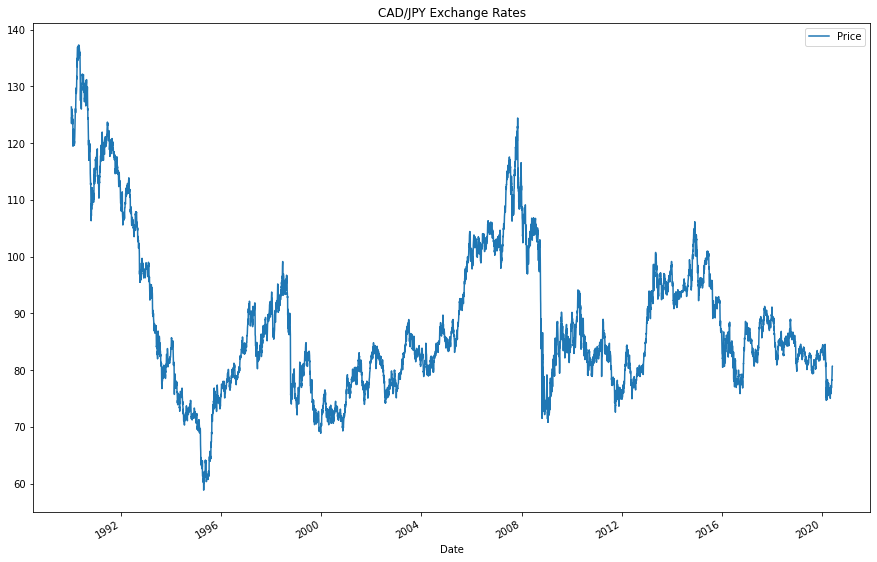

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=[15,10],title='CAD/JPY Exchange Rates',legend=True)

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** When we see the Plot above we can see weakening value of Japanese Yen against the Canadian Dollars on Long-term basis . Although there is seems a conistent trend on average but there are various ups and downs on daily basis  

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])
# reset and set index for ts_trend
ts_trend = ts_trend.reset_index()
ts_trend = ts_trend.set_index("Date")

In [6]:
# reset and set index for ts_noise
ts_noise = ts_noise.reset_index()
ts_noise = ts_noise.set_index("Date")

In [7]:
# renaming ts_trend columns from "Price_trend" to "trends"
ts_trend.rename(columns ={'Price_trend':'trend'}, inplace=True)
ts_trend.head()

,trend
Date,
1990-01-02,125.850905
1990-01-03,125.679684
1990-01-04,125.508788
1990-01-05,125.338304
1990-01-08,125.167037


In [8]:
# renaming ts_trend columns from "Price_cycle" to "noise"
ts_noise.rename(columns = {'Price_cycle':'noise'}, inplace=True)
ts_noise.head()

,noise
Date,
1990-01-02,0.519095
1990-01-03,-0.379684
1990-01-04,-2.048788
1990-01-05,-0.798304
1990-01-08,-0.897037


In [9]:
 # Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
futures_decompose = cad_jpy_df[["Price"]].copy()
futures_decompose['noise'] = ts_noise
futures_decompose['trend'] = ts_trend
futures_decompose.tail()

,Price,noise,trend
Date,,,
2020-05-29,78.29,-0.503961,78.793961
2020-06-01,79.27,0.218939,79.051061
2020-06-02,80.40,1.088117,79.311883
2020-06-03,80.70,1.125501,79.574499
2020-06-04,80.71,0.872339,79.837661


In [10]:
# Using Loc function to plot the data from 2015 to the present
price_vs_trend_2015_present = futures_decompose.loc["2015":"2022"]
price_vs_trend_2015_present

,Price,noise,trend
Date,,,
2015-01-01,103.12,1.523927,101.596073
2015-01-02,102.25,0.945717,101.304283
2015-01-05,101.70,0.708200,100.991800
2015-01-06,100.04,-0.620865,100.660865
2015-01-07,100.93,0.615839,100.314161
...,...,...,...
2020-05-29,78.29,-0.503961,78.793961
2020-06-01,79.27,0.218939,79.051061
2020-06-02,80.40,1.088117,79.311883


<AxesSubplot:title={'center':'Price vs Trend'}, xlabel='Date'>

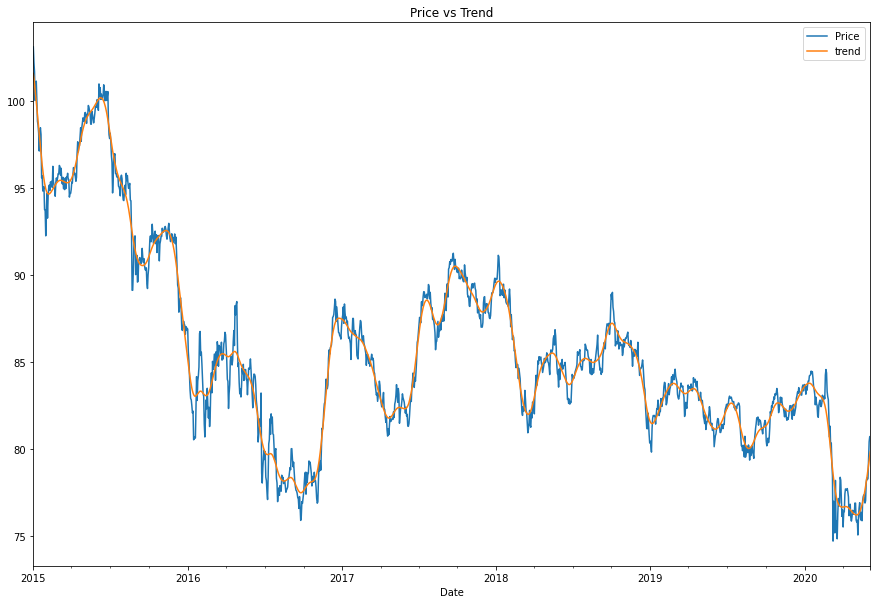

In [11]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
price_vs_trend_2015_present.plot(y=["Price", "trend"],figsize=[15,10],title='Price vs Trend',legend=True)

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** HP Filter helps smoothing and plotting the result of trend against the actual price, it shows the short term fluctuations around the trends, these could help to gauge profitable trading opportunities, when the Price represent by blue shows far below the orange representing the trend, It shows as a indicator that the JYP Yen is temporarily less valued than it should, we could see this as a short-term buying opportunity.

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

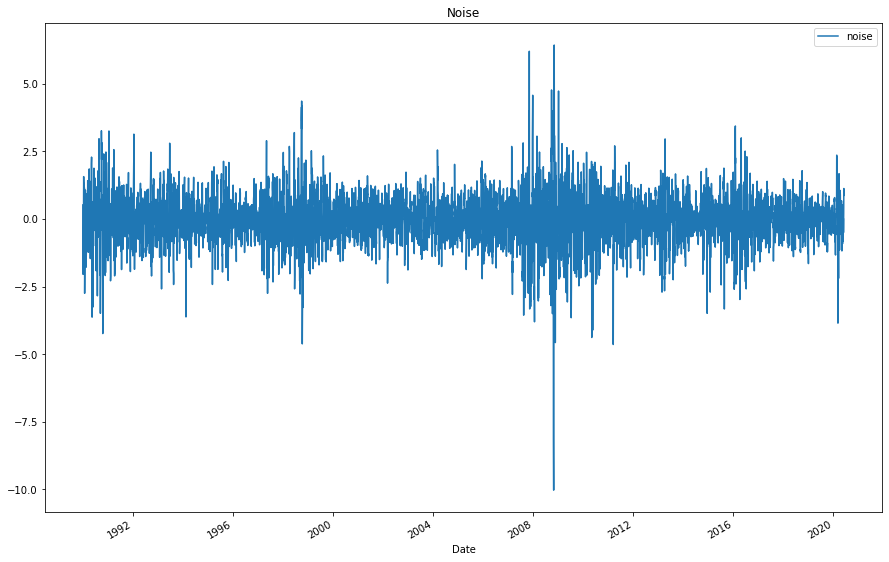

In [12]:
# Plot the Settle Noise
futures_decompose.plot(y='noise',figsize=[15,10],title='Noise',legend=True)

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [13]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [14]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

In [15]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
ARMA_model = ARMA(returns.values, order=(2,0,1))

# Fit the model and assign it to a variable called results
results = ARMA_model.fit()

In [16]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 0)   Log Likelihood               -9752.313
Method:                       css-mle   S.D. of innovations              0.828
Date:                Tue, 31 May 2022   AIC                          19512.625
Time:                        18:57:30   BIC                          19540.538
Sample:                             0   HQIC                         19522.184
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.246      0.806      -0.020       0.015
ar.L1.y       -0.0304      0.011     -2.710      0.007      -0.052      -0.008
ar.L2.y       -0.0021      0.011     -0.188      0.851      -0.024       0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.2007          -20.5257j           21.7521           -0.3037
AR.2           -7.2007          +20.5257j           21.7521            0.3037
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

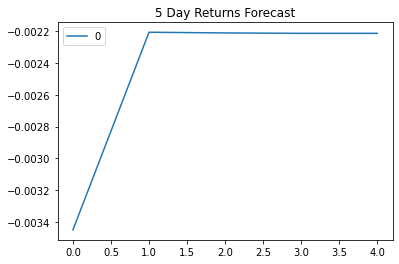

In [17]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** The model is not a good fit the p-value exceeds 0.05.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [18]:
from statsmodels.tsa.arima.model import ARIMA
# Estimate and ARIMA Model:
model1 = ARIMA(cad_jpy_df["Price"].values, order=(5, 1, 1))
# Run ARIMA model Fit the model
results_1 = model1.fit()

# Output model summary results:
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7929
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.898
Date:                Tue, 31 May 2022   AIC                          17505.796
Time:                        18:57:35   BIC                          17554.643
Sample:                             0   HQIC                         17522.523
                               - 7929                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4303      0.331      1.299      0.194      -0.219       1.080
ar.L2          0.0178      0.012      1.459      0.145      -0.006       0.042
ar.L3         -0.0118      0.009     -1.313      0.189      -0.029       0.006
ar.L4          0.0110      0.008      1.299      0.194      -0.006       0.028
ar.L5         -0.0191      0.007     -2.706      0.007      -0.033      -0.005
ma.L1         -0.4583      0.332     -1.381      0.167      -1.109       0.192
sigma2         0.5318      0.004    118.418      0.000       0.523       0.541
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9233.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

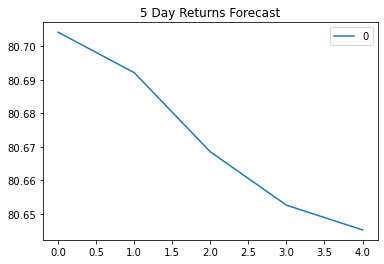

In [19]:
# Plot the 5 Day Price Forecast
future_price_forecast= results_1.forecast(steps = 5, exog=None, alpha=0.05)

pd.DataFrame(future_price_forecast).plot(title="5 Day Returns Forecast")


**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The Model show the value of Yen decreasing or has a negative movement long-term


---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [20]:
# Installing arch
!pip install arch

In [21]:
#Importing arch_model from arch
from arch import arch_model

In [22]:
# Estimate a GARCH model:
model = arch_model(returns["Price"], mean="Zero", vol="GARCH", p=2,q=1)
# Fit the model
result=model.fit(disp="off")

In [23]:
# Summarize the model results
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Tue, May 31 2022   Df Residuals:                     7928
Time:                        18:57:40   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [24]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [25]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = result.forecast(start= last_day, horizon=forecast_horizon)
forecasts

In [26]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [27]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:>

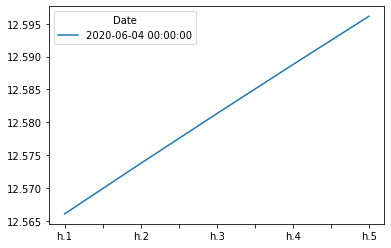

In [28]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Based on the model above, the forecast for CAD/JPY volatility is that it is expected to increase over next 5 days.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

Based on the time series analysis Yen should not be buy this time, however if a good model is found and other factor is also take into decision it might be a good consideration to buy near future.

2. Is the risk of the yen expected to increase or decrease?
    
  
Based on The amount of volatility with Japanese Yen indicates that the currency is very risky to purchase now.
Altough both models also showing conflicting results ARIMA predicts that the Yen will decrease when the GARCH indicates that Japanese Yen will increase in value. Until the best model fitting is found and adjusted to right fitting, then it will show a better and accurate risk anyalisis.



3. Based on the model evaluation, would you feel confident in using these models for trading?

Based on all the models I would **NOT** suggest using them until the best model fitting is found and adjusted to right fitting, then it will show a better and accurate results. 